In [1]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs

In [2]:
! pip install OmegaConf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 3.9 MB/s 
     |████████████████████████████████| 117 kB 11.1 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=203da6f5600f8782159be0d01fca6f6fd112502982f52ed44290f44cf96884e7
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime


In [3]:
import jax
from jax.example_libraries import stax, optimizers
from jax.scipy.special import logsumexp
from jax import value_and_grad
import jax.numpy as jnp
import itertools
from omegaconf import OmegaConf
import seaborn as sns

In [26]:
def create_mlp(n_hid_layers, hid_dim, output_dim):
    layers = list(itertools.chain.from_iterable(
        [(stax.Dense(hid_dim), stax.Relu) for _ in range(n_hid_layers)]
    )) + [stax.Dense(output_dim)]
    mpl_init, mpl_apply = stax.serial(*layers)
    return mpl_init, mpl_apply

def model_predict(params, apply_fun, data):
  return apply_fun(params, data)

def iterable_dataset(key, data, batch_size):
    data_x, data_y = data
    assert len(data_x) == len(data_y)
    n_samples = len(data_x)
    n_batches = n_samples // batch_size
    x_shuffled, y_shuffled = jnp.split(
        jax.random.permutation(
            key, jnp.concatenate([data_x, data_y], axis=-1)
        ),
        2, axis=-1
    )
    dataset = [
        (
            x_shuffled[i * batch_size: (i + 1) * batch_size],
            y_shuffled[i * batch_size: (i + 1) * batch_size],
        ) for i in range(n_batches)
    ]
    return dataset

def plot_losses(losses_dict):
    for key, vals in losses_dict.items():
        plt.plot(vals, label=key)
    plt.legend()
    plt.show()

def show_predictions(model_params, model_apply, data):
    x, y = data
    pred_y = model_apply(model_params, x)
    pred_y = np.argmax(pred_y, axis=-1)
    # print(np.unique(pred_y))
    # sns.scatterplot(alpha=0.5, x=x[:, 0], y=x[:, 1], hue=y, ='real_data')
    # plt.show()
    sns.scatterplot(alpha=0.5, x=x[:, 0], y=x[:, 1], hue=pred_y, label='predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def run_model(data, hparams, test_data=None, x_dim=2, y_dim=3, seed=10):
    x,_ = data
    aug_x = make_preturb_data(x, noise_peterb=10**-4)
    
    key = jax.random.PRNGKey(seed)
    key, key_model = jax.random.split(key, 2)
    model_init, model_apply = create_mlp(
        n_hid_layers=hparams.model.n_layers,
        hid_dim=hparams.model.hidden_dim,
        output_dim=y_dim)
    _, model_params = model_init(key_model, (-1, x_dim))
    

    #inti optimizer
    model_opt_init, model_opt_update, model_get_params = optimizers.adam(
        step_size=hparams.lr
    )
    model_opt_state = model_opt_init(model_params)

    def train_step(step_num, model_opt_state,x, aug_x):
      params = model_get_params(model_opt_state)
      loss, grad = value_and_grad(loss_fun)(params, model_apply, x, aug_x)
      return loss, model_opt_state

    def softmaxed_cross_entropy_loss(y_true, y_pred):
        log_prob = y_pred - logsumexp(y_pred, axis=1)[:,None]
        return -jnp.mean(log_prob * y_true)

    def loss_fun(params, apply_fun, x, aug_x, alpha=0.5):
      pred1 = model_predict(params, apply_fun, x)
      pred2 = model_predict(params, apply_fun, aug_x)

      loss_1 = softmaxed_cross_entropy_loss(pred1, pred2)
      loss_2 = softmaxed_cross_entropy_loss(pred2, pred1)

      return alpha*(loss_1+loss_2)

    total_step = 0
    loss_history = [] 
    for epoch in range(hparams.epochs):
        key, key_data = jax.random.split(key)
        
        for batch_x, batch_aug_x in iterable_dataset(key_data, (x, aug_x), batch_size=hparams.batch_size):
            
            loss, model_opt_state = train_step(
                step_num=total_step,
                model_opt_state=model_opt_state,
                x=batch_x,
                aug_x=batch_aug_x,
            )
            
            loss_history.append(loss)
            
            total_step += 1
            
        if epoch == 0 or (epoch < 100 and epoch % 10 == 9) or epoch % 100 == 99:
            print('-' * 30, 'epoch', epoch, '-' * 30)
            plot_losses({'loss': loss_history})
            if test_data:
              show_predictions(model_get_params(model_opt_state), model_apply, test_data)

In [32]:
x, label = make_blobs(10000, n_features=2, centers=3, random_state=100)
colormap = np.array(['r', 'g', 'b'])

data = (x, label)

In [33]:
label

array([1, 1, 0, ..., 1, 0, 1])

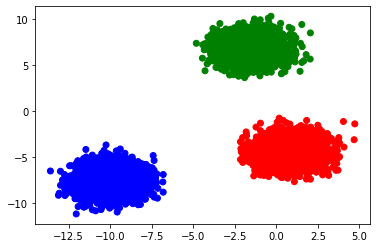

In [34]:
plt.scatter(x[:,0],x[:,1], c=colormap[label])

In [35]:
# data peterbations
def make_preturb_data(data, noise_peterb=10**-4):
    preturb_data = data+np.random.normal(scale=noise_peterb,size=data.shape)
    return preturb_data

#to one_hot
def convert_to_one_hot(data):
    # assuming there is label from all classes
    one_hot = np.zeros((data.size, data.max() + 1))
    one_hot[np.arange(data.size), data] = 1
    return one_hot

In [ ]:
# modeling

#one hidden layer model
# in layer 2 neurons
# hidden layer 2 neurons
# out layer 3 neurons, softmaxed

In [23]:
np.unique(label)

array([0, 1, 2])

------------------------------ epoch 0 ------------------------------


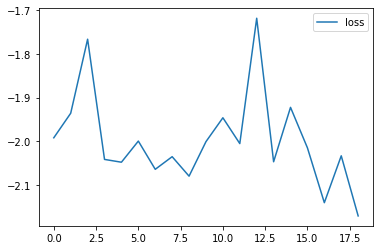

[1 2]


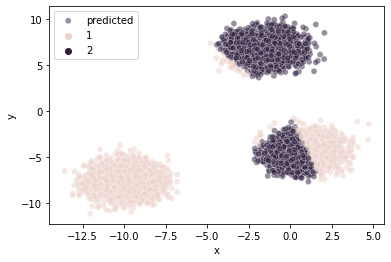

------------------------------ epoch 9 ------------------------------


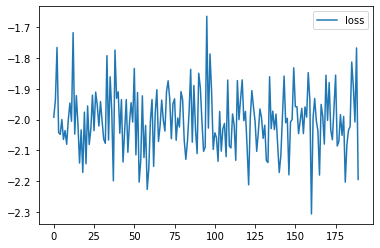

[1 2]


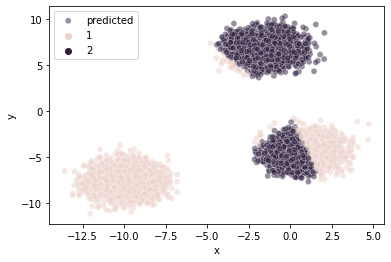

KeyboardInterrupt: ignored

In [36]:
hyper_params = OmegaConf.create({
    'epochs': 500,
    'batch_size': 512,
    'lr': 0.0001,
    'model': {
        'n_layers': 1,
        'hidden_dim': 10,
    },
})
run_model(data, hyper_params, test_data=data)

- There are problems with current implementation. The loss does not decrease
- Maybe it is easy for image classification task